# Value Based Clustering

The goal is to identify which customers contribute the most financially and the ones who bring more value for the company.

### Number of Clusters

Without outliers:

      Evaluate the Number of Clusters with Hierarchical Clustering

      Evaluate the Number of Clusters with K-Means

With outliers:

      GMM

      Mean Shift

      DBSCAN

### Cluster Profilling (Best Result)

In [289]:
# Jupyter notebook: optional formatting extension
# %load_ext nb_black

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import datetime
import math
from math import ceil

# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer

# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor

# Clustering evaluation
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Stats
from scipy.stats import chi2_contingency, stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.mosaicplot import mosaic

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Model selection
from sklearn.model_selection import GridSearchCV

# Geospatial
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import geopandas as gpd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import matplotlib.cm as cm


In [290]:
df_value_based = pd.read_csv("df_ready_for_clustering.csv")
df_value_based.head()

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,LoyaltyIndex,CustomerSegment,HasBonus,TotalFlights,sr_jan,...,Education,Income,Marital Status,LoyaltyStatus,EnrollmentMonth,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value
0,0.387904,0.200000,2356.577778,25.786888,32446,709.589704,Moderate traveler and high redeemed,0,225,0.026667,...,Bachelor,82877.0,Married,Aurora,8,874,N,0,Standard,7919.20
1,0.553363,0.224490,1384.141224,18.077435,15141,418.130598,Low traveler and low redeemed,0,245,0.077551,...,College,0.0,Single,Nova,3,2122,N,0,Standard,2887.74
2,0.113362,0.241706,2047.539336,88.241585,38293,616.640254,Moderate traveler and low redeemed,0,211,0.094787,...,College,0.0,Divorced,Nova,7,884,N,0,Standard,2838.07
3,0.354092,0.157407,3375.941667,28.248369,23544,1014.088728,High traveler and high redeemed,0,108,0.000000,...,Bachelor,42837.0,Married,Star,8,1242,N,0,Standard,4170.57
4,0.253580,0.276243,2373.649171,39.448214,32058,714.181936,Moderate traveler and high redeemed,0,181,0.022099,...,Bachelor,80979.0,Divorced,Star,1,1816,N,0,Standard,6622.05


In [291]:
df_value_based.columns

Index(['PointsRedeemedRatio', 'FlightsWithCompanionsRatio',
       'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints',
       'LoyaltyIndex', 'CustomerSegment', 'HasBonus', 'TotalFlights', 'sr_jan',
       'sr_feb', 'sr_mar', 'sr_apr', 'sr_may', 'sr_jun', 'sr_jul', 'sr_aug',
       'sr_sep', 'sr_oct', 'sr_nov', 'sr_dec', 'Province or State',
       'Education', 'Income', 'Marital Status', 'LoyaltyStatus',
       'EnrollmentMonth', 'Time on Program', 'Cancelled', 'Reenroll',
       'EnrollmentType', 'Customer Lifetime Value'],
      dtype='object')

In [292]:
value_features = [

    'Customer Lifetime Value',
    'UnredeemedPoints',
    'PointsRedeemedRatio',
    'KMPerRedeemedPoint',
    'AvgDistancePerFlight',
    'FlightsWithCompanionsRatio',
    'TotalFlights'
]

df_value_based = df_value_based[value_features]


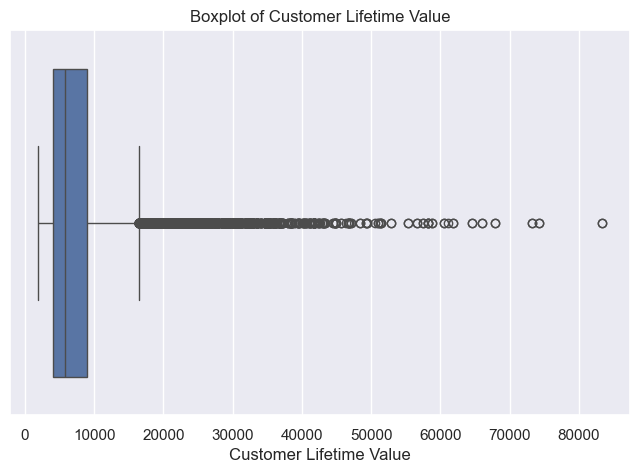

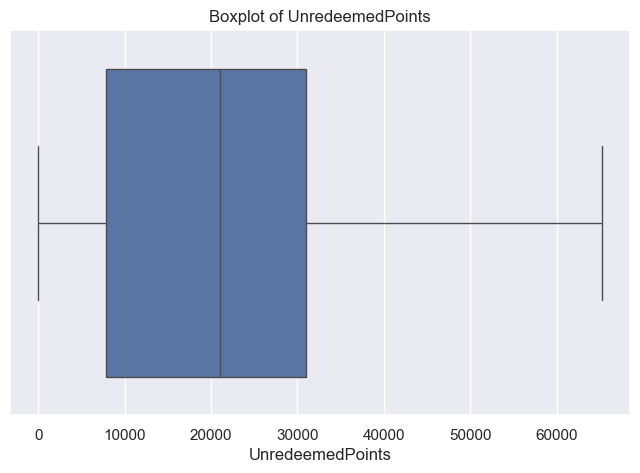

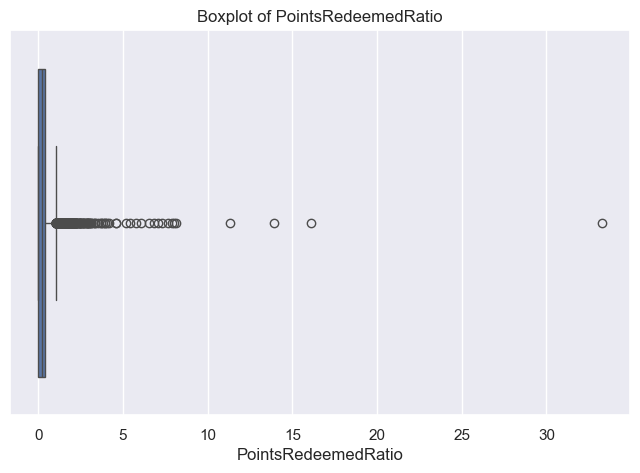

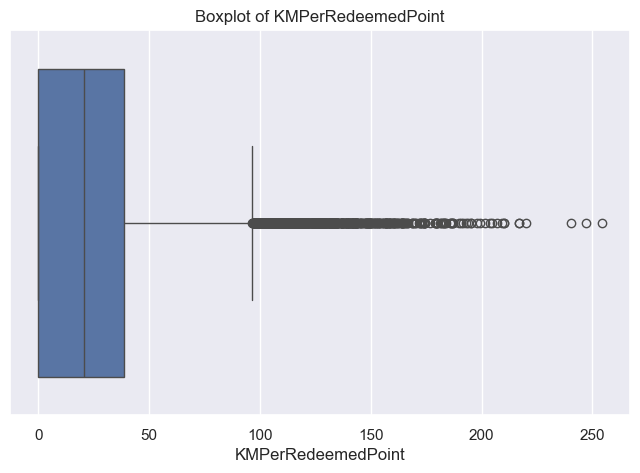

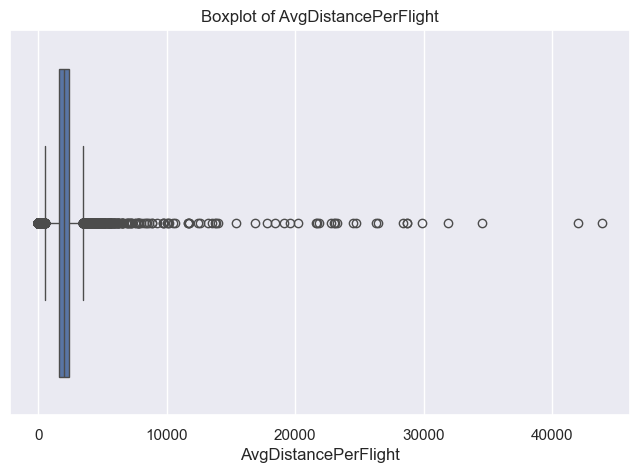

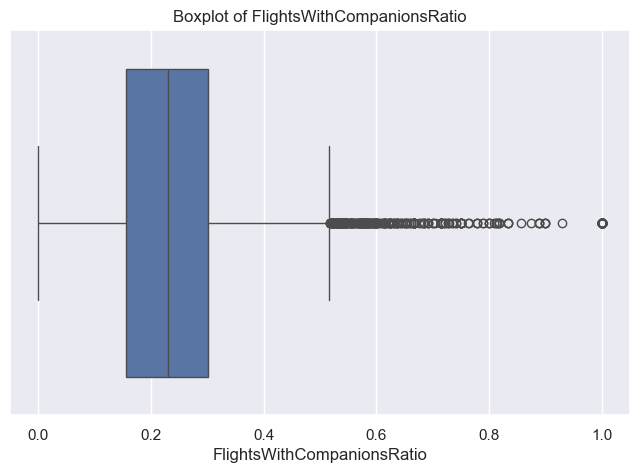

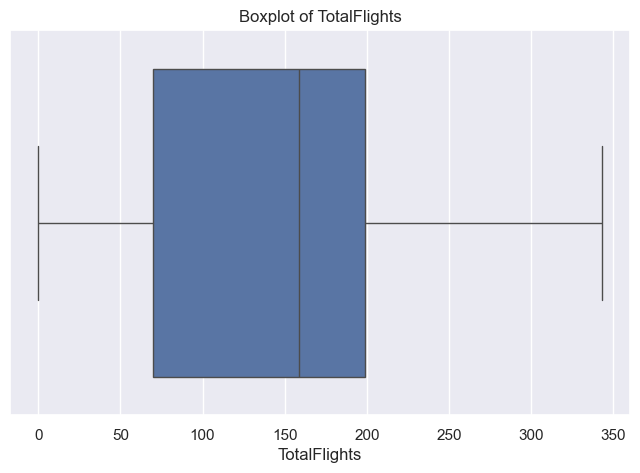

In [293]:
# I want to visualize the outliers in each column using boxplots
for column in df_value_based.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df_value_based[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.show()

In [294]:
# Transform the features in df_value_based as needed (e.g., scaling, normalization)
scaler = StandardScaler()
df_value_based_scaled = scaler.fit_transform(df_value_based)  

df_value_based = pd.DataFrame(df_value_based_scaled, columns=value_features)

We will remove and keep outliers from the dataset with DBSCAN

In [295]:
def count_outliers_for_columns(df, column_names):
    """
    Count the number of outliers for each specified column in a DataFrame using the IQR method.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_names (list): A list of column names to analyze.

    Returns:
    list: A list of tuples where each tuple contains the column name and the number of outliers.
    """
    outliers_count_list = []

    for column_name in column_names:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[column_name].quantile(0.25)
        Q3 = df[column_name].quantile(0.75)

        # Calculate IQR (Interquartile Range)
        IQR = Q3 - Q1

        # Define outliers as values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count the outliers
        outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
        outlier_count = outliers.shape[0]

        # Append the result as a tuple (column_name, outlier_count)
        x = "{p}%".format(p = int(outlier_count/df.shape[0]*1000)/10)
        outliers_count_list.append((column_name, outlier_count,x))

    return outliers_count_list

# Example usage:
# Assuming df is your DataFrame and you have a list of column names
outliers_counts = count_outliers_for_columns(df_value_based, df_value_based.columns)

for col in outliers_counts:
    print(col)

('Customer Lifetime Value', 1460, '8.8%')
('UnredeemedPoints', 0, '0.0%')
('PointsRedeemedRatio', 408, '2.4%')
('KMPerRedeemedPoint', 766, '4.6%')
('AvgDistancePerFlight', 2042, '12.3%')
('FlightsWithCompanionsRatio', 317, '1.9%')
('TotalFlights', 0, '0.0%')


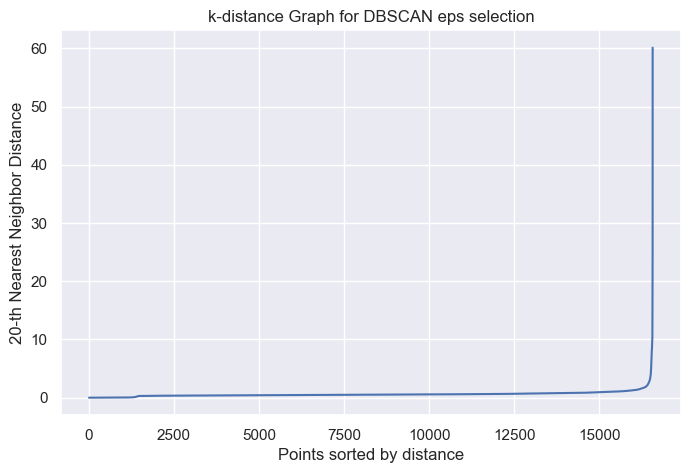

In [296]:
X = df_value_based.values  # DBSCAN input
min_samples = 20

# Compute nearest neighbors
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Use distance to the kth neighbor
k_distances = np.sort(distances[:, -1])
plt.figure(figsize=(8,5))
plt.plot(k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{min_samples}-th Nearest Neighbor Distance')
plt.title('k-distance Graph for DBSCAN eps selection')
plt.grid(True)
plt.show()


In [297]:
# Cell 7: Remove outliers using DBSCAN
from collections import Counter
dbscan = DBSCAN(eps=2.0, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df_value_based)

# Check outlier count
outlier_count = Counter(dbscan_labels)
print(f"DBSCAN results: {outlier_count}")
print(f"Outliers detected: {outlier_count[-1]}")
print(f"Core customers: {outlier_count[0]}")

# Save outliers for later classification
df_out = df_value_based[dbscan_labels == -1].copy()

# Filter to core customers only
df = df_value_based[dbscan_labels != -1].copy()
print(f"\nWorking with {len(df):,} core customers")
print(f"Outliers saved for later: {len(df_out)}")

DBSCAN results: Counter({np.int64(0): 16478, np.int64(-1): 96})
Outliers detected: 96
Core customers: 16478

Working with 16,478 core customers
Outliers saved for later: 96


# Hierarchical Clustering 

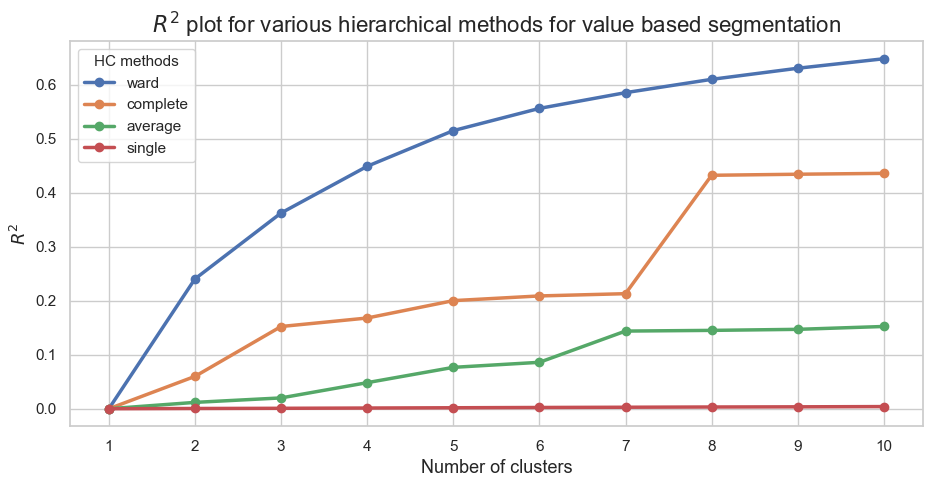

In [298]:

def get_ss(df, feats):
    """Compute total sum of squares (SST) for features in df."""
    X = df[feats].values
    mean_vec = X.mean(axis=0)
    return ((X - mean_vec)**2).sum()

def get_ssw(df, feats, label_col):
    """Compute sum of squares within clusters (SSW)."""
    X = df[feats].values
    labels = df[label_col].values
    ssw = 0
    for lbl in np.unique(labels):
        cluster_points = X[labels == lbl]
        cluster_mean = cluster_points.mean(axis=0)
        ssw += ((cluster_points - cluster_mean)**2).sum()
    return ssw

def get_rsq(df, feats, label_col):
    """Compute R² for clustering solution."""
    sst = get_ss(df, feats)
    ssw = get_ssw(df, feats, label_col)
    ssb = sst - ssw
    return ssb / sst


def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """Compute R² for a range of cluster solutions."""
    r2 = []
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus + 1):
        cluster = AgglomerativeClustering(
            n_clusters=i,
            metric=dist,
            linkage=link_method
        )
        hclabels = cluster.fit_predict(df[feats])
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)
        r2.append(get_rsq(df_concat, feats, 'labels'))
    
    return np.array(r2)


metric_features = df.columns.tolist()  # your numeric features for clustering
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

results = []

for link in hc_methods:
    r2 = get_r2_hc(
        df=df[metric_features],
        link_method=link,
        max_nclus=max_nclus,
        min_nclus=1,
        dist="euclidean"
    )
    results.append(r2)

r2_hc = np.vstack(results)


sns.set(style="whitegrid")
plt.figure(figsize=(11,5))

for i, link in enumerate(hc_methods):
    plt.plot(range(1, max_nclus + 1), r2_hc[i], marker='o', linewidth=2.5, label=link)

plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("$R^2$", fontsize=13)
plt.xticks(range(1, max_nclus + 1))
plt.title("$R^2$ plot for various hierarchical methods for value based segmentation", fontsize=16)
plt.legend(title="HC methods", title_fontsize=11)
plt.show()


Ward linkage is the best method, since it gets the best r2 across all clusters.

In [299]:
from scipy.cluster.hierarchy import linkage
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
distance = 'euclidean' 
n_clusters = None 

linkage_matrix= linkage(df, method="ward") 

In [300]:
linkage_matrix.shape

# Column	Meaning
# 0	        Index of first cluster merged
# 1	        Index of second cluster merged
# 2	        Distance between them at merge (height in dendrogram)
# 3	        Number of original observations contained in the new cluster

(16477, 4)

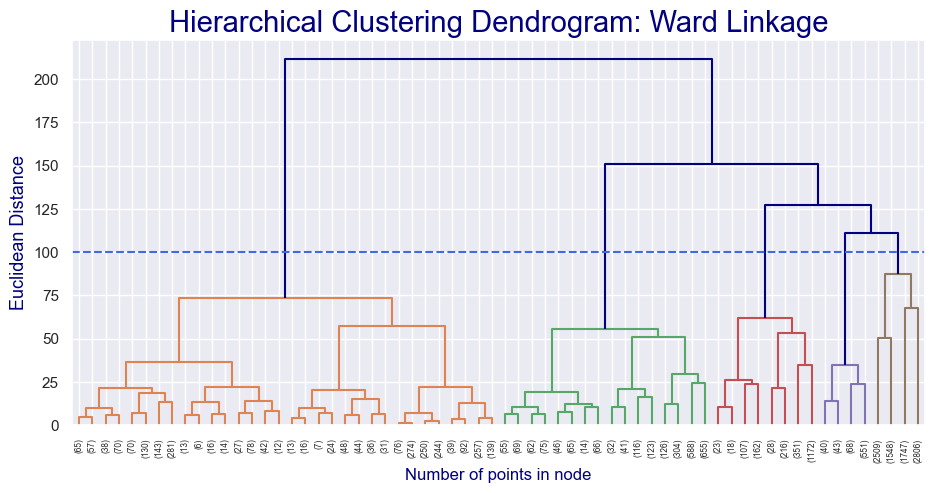

In [301]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
Y_THRESHOLD = 100 
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=Y_THRESHOLD, above_threshold_color='navy')
    # You can play with 'truncate_mode' and 'p' define what level the dendrogram shows
    # above_threshold_color='k' forces black color for the lines above the threshold)
plt.hlines(Y_THRESHOLD, 0, 1000, colors="royalblue", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: Ward Linkage', fontsize=21, color='navy')
plt.xlabel('Number of points in node', color='navy')
plt.ylabel(f'{distance.title()} Distance', fontsize=13, color='navy')
plt.show()

let's try with nclusters = 3 and nclusters=4

In [302]:
linkage = "ward" 
distance = "euclidean" 
n_clusters = 3
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels3 = hclust.fit_predict(df)

In [303]:
df_concat = pd.concat([
    df, 
    pd.Series(hc_labels3, name='labels', index=df.index)
    ], 
    axis=1)
df_concat.groupby('labels').mean().T

labels,0,1,2
Customer Lifetime Value,-0.007709,0.004659,-0.041751
UnredeemedPoints,0.058478,-1.206714,1.086759
PointsRedeemedRatio,0.169411,-0.587605,-0.320953
KMPerRedeemedPoint,-0.189337,-0.869716,1.859500
AvgDistancePerFlight,0.083391,-0.742765,0.185572
FlightsWithCompanionsRatio,0.267034,-1.307080,0.089202
TotalFlights,0.238789,-1.531720,0.608902


In [304]:
# Features used for clustering
X = df

# Compute metrics
silhouette = silhouette_score(X, hc_labels3)
calinski_harabasz = calinski_harabasz_score(X, hc_labels3)
davies_bouldin = davies_bouldin_score(X, hc_labels3)

# Display results
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)


Silhouette Score: 0.2325051619730926
Calinski-Harabasz Index: 4682.002635931123
Davies-Bouldin Index: 1.2903803972702892


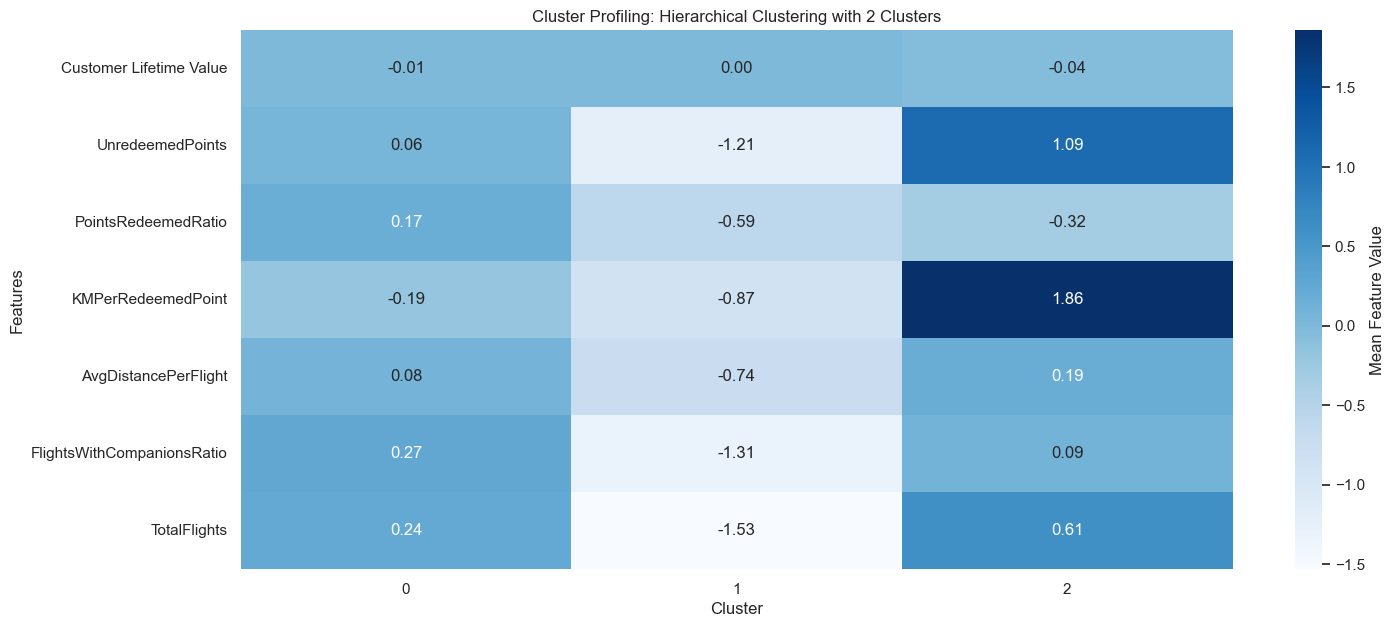

In [305]:
X = df.copy()
X['labels'] = hc_labels3

cluster_means = X.groupby('labels')[value_features].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 2 Clusters")
plt.yticks(rotation=0)
plt.show()


In [306]:
# 4 cluster solution

linkage = "ward" 
distance = "euclidean" 
n_clusters = 4
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels4 = hclust.fit_predict(df)

In [307]:
df_concat = pd.concat([
    df, 
    pd.Series(hc_labels4, name='labels', index=df.index)
    ], 
    axis=1)
df_concat.groupby('labels').mean().T

labels,0,1,2,3
Customer Lifetime Value,0.018441,0.004659,-0.041751,-0.124949
UnredeemedPoints,0.283659,-1.206714,1.086759,-0.951097
PointsRedeemedRatio,0.116206,-0.587605,-0.320953,0.407953
KMPerRedeemedPoint,-0.147983,-0.869716,1.859500,-0.374745
AvgDistancePerFlight,0.061231,-0.742765,0.185572,0.182743
FlightsWithCompanionsRatio,0.135088,-1.307080,0.089202,0.858602
TotalFlights,0.529174,-1.531720,0.608902,-1.063120


In [308]:
# Features used for clustering
X = df

# Compute metrics
silhouette = silhouette_score(X, hc_labels4)
calinski_harabasz = calinski_harabasz_score(X, hc_labels4)
davies_bouldin = davies_bouldin_score(X, hc_labels4)

# Display results
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)


Silhouette Score: 0.23188940317063883
Calinski-Harabasz Index: 4472.4073001069555
Davies-Bouldin Index: 1.443122811433385


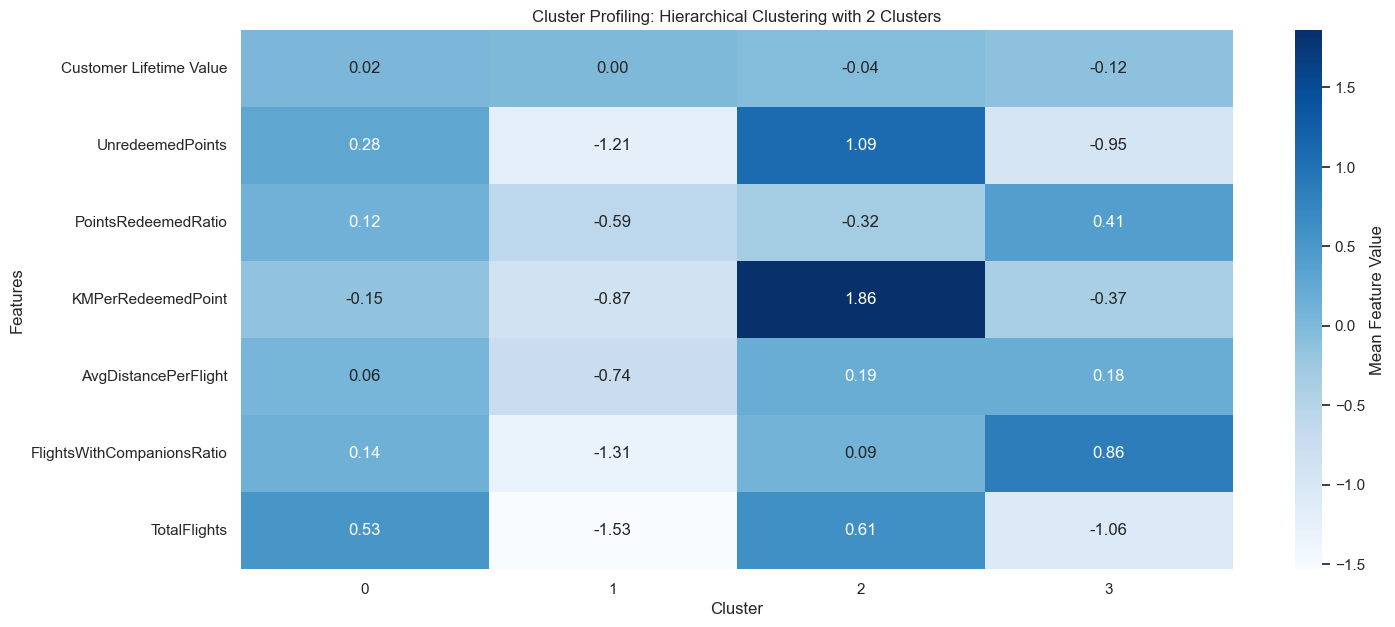

In [309]:
Y = df.copy()
Y['labels'] = hc_labels4

cluster_means = Y.groupby('labels')[value_features].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 2 Clusters")
plt.yticks(rotation=0)
plt.show()


In [310]:
## See crosstab of 3 vs 2

pd.crosstab(
    pd.Series(hc_labels3, name='hc3_labels', index=df.index),
    pd.Series(hc_labels4, name='hc4_labels', index=df.index),
    )

hc4_labels,0,1,2,3
hc3_labels,,,,
0,9312,0,0,2077
1,0,2652,0,0
2,0,0,2437,0


# K-means Clustering 

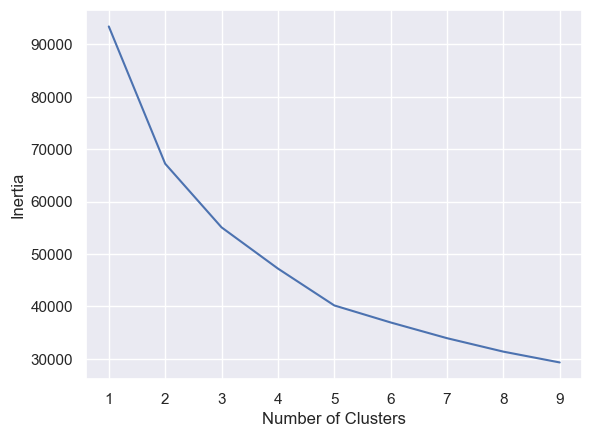

In [311]:
# Lets use the elbow method to find the best number of clusters

n_clusters = range(1, 10)
sse2 = []

for k in n_clusters:
    km = KMeans(n_clusters=k, init = "k-means++", max_iter=300, n_init=10)
    km.fit(df)
    sse2.append(km.inertia_)

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.plot(n_clusters, sse2)  
plt.show()

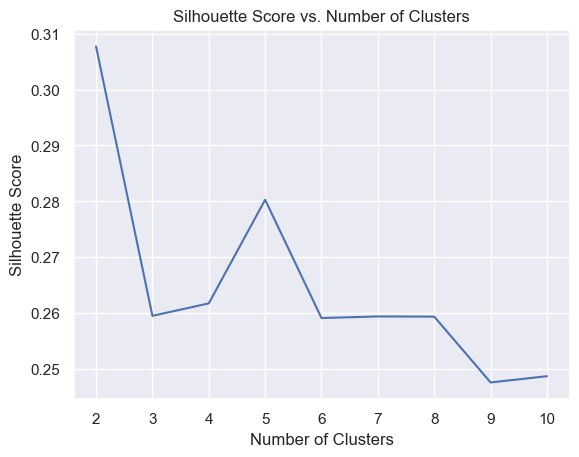

In [312]:
s_scores = []
n_clusters = range(2, 11)
for k in n_clusters:
    kmeans = KMeans(n_clusters=k, init="k-means++", max_iter=300, n_init=10, random_state=94)  # Set random_state for reproducibility
    kmeans.fit(df)
    score = silhouette_score(df, kmeans.labels_)
    s_scores.append(score)

# Plot silhouette scores dynamically
plt.figure()  # Create a new figure for each iteration
plt.plot(n_clusters, s_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title(f'Silhouette Score vs. Number of Clusters')
plt.show()

Let's try nclusters=2,3,4,5

cluster,0,1
Customer Lifetime Value,-0.020232,-0.005864
UnredeemedPoints,-1.078066,0.566549
PointsRedeemedRatio,-0.012013,-0.031617
KMPerRedeemedPoint,-0.654153,0.343721
AvgDistancePerFlight,-0.308947,0.107113
FlightsWithCompanionsRatio,-0.277836,0.124192
TotalFlights,-1.141406,0.601711


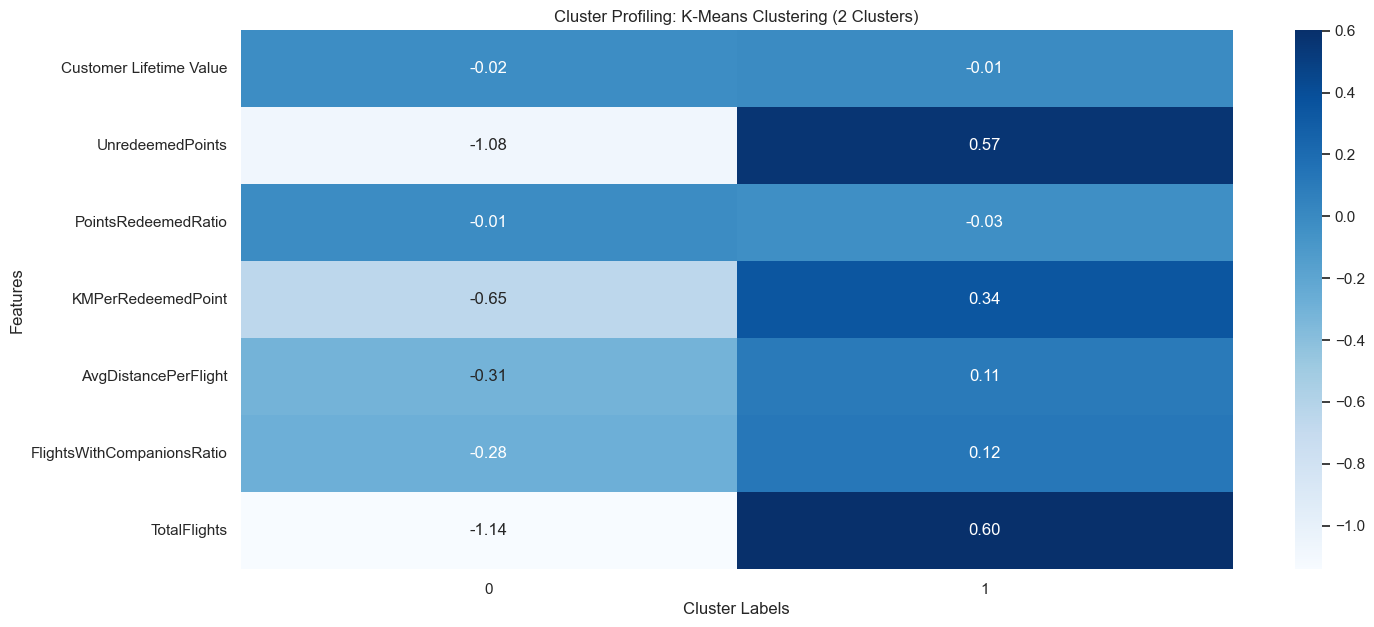

In [313]:
km = KMeans(n_clusters=2, init="k-means++", random_state=94)
km_labels_2 = km.fit_predict(df)

df_value_based_with_clusters = df.copy()
df_value_based_with_clusters['cluster'] = km_labels_2

cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (2 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()


cluster,0,1,2
Customer Lifetime Value,-0.061420,0.008102,0.042363
UnredeemedPoints,-0.638379,0.817005,-1.271919
PointsRedeemedRatio,0.406192,-0.164384,-0.549001
KMPerRedeemedPoint,-0.384555,0.516139,-0.848496
AvgDistancePerFlight,0.144501,0.105076,-0.929307
FlightsWithCompanionsRatio,0.579858,0.005346,-1.451761
TotalFlights,-0.314085,0.683606,-1.557155


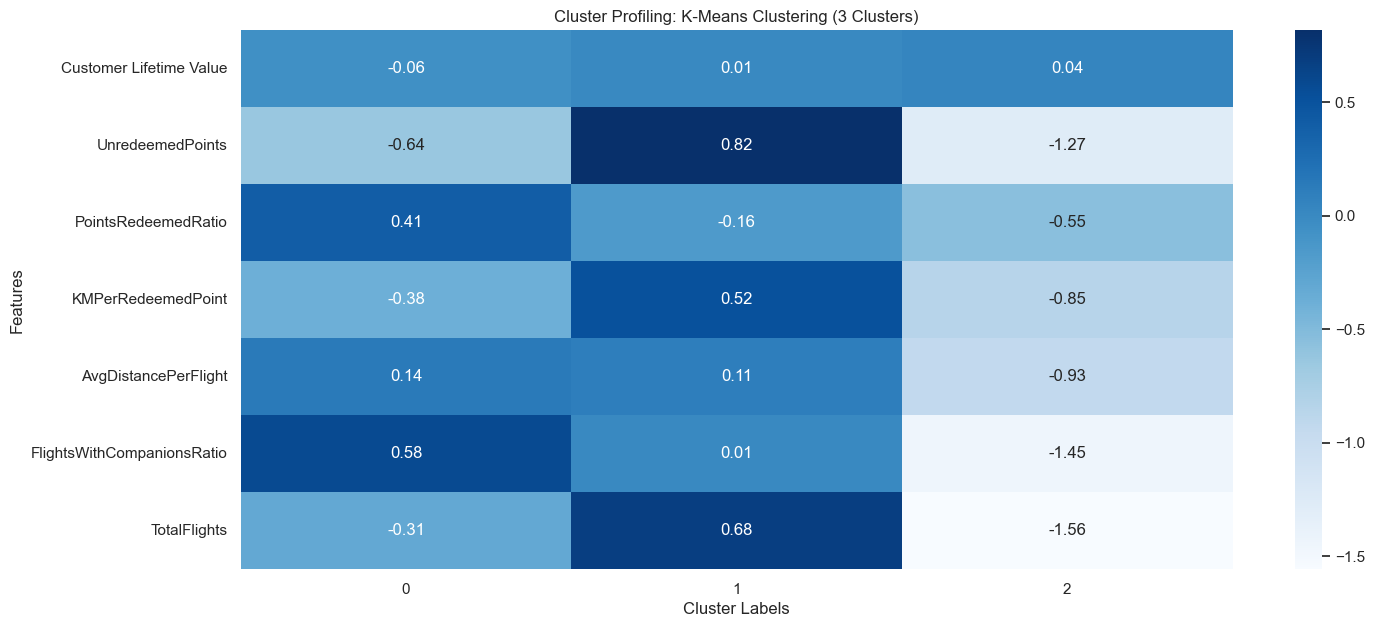

In [314]:
km = KMeans(n_clusters=3, init="k-means++", random_state=94)
km_labels_3 = km.fit_predict(df)

df_value_based_with_clusters = df.copy()
df_value_based_with_clusters['cluster'] = km_labels_3

cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (3 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()


cluster,0,1,2,3
Customer Lifetime Value,-0.027364,0.056548,0.043368,-0.046602
UnredeemedPoints,0.522255,1.136615,-1.285274,-0.839375
PointsRedeemedRatio,-0.020698,-0.345395,-0.554692,0.447350
KMPerRedeemedPoint,-0.079559,2.024610,-0.849531,-0.427938
AvgDistancePerFlight,0.072318,0.172535,-0.956734,0.185037
FlightsWithCompanionsRatio,0.040601,0.020482,-1.478282,0.719051
TotalFlights,0.629439,0.640457,-1.570710,-0.605121


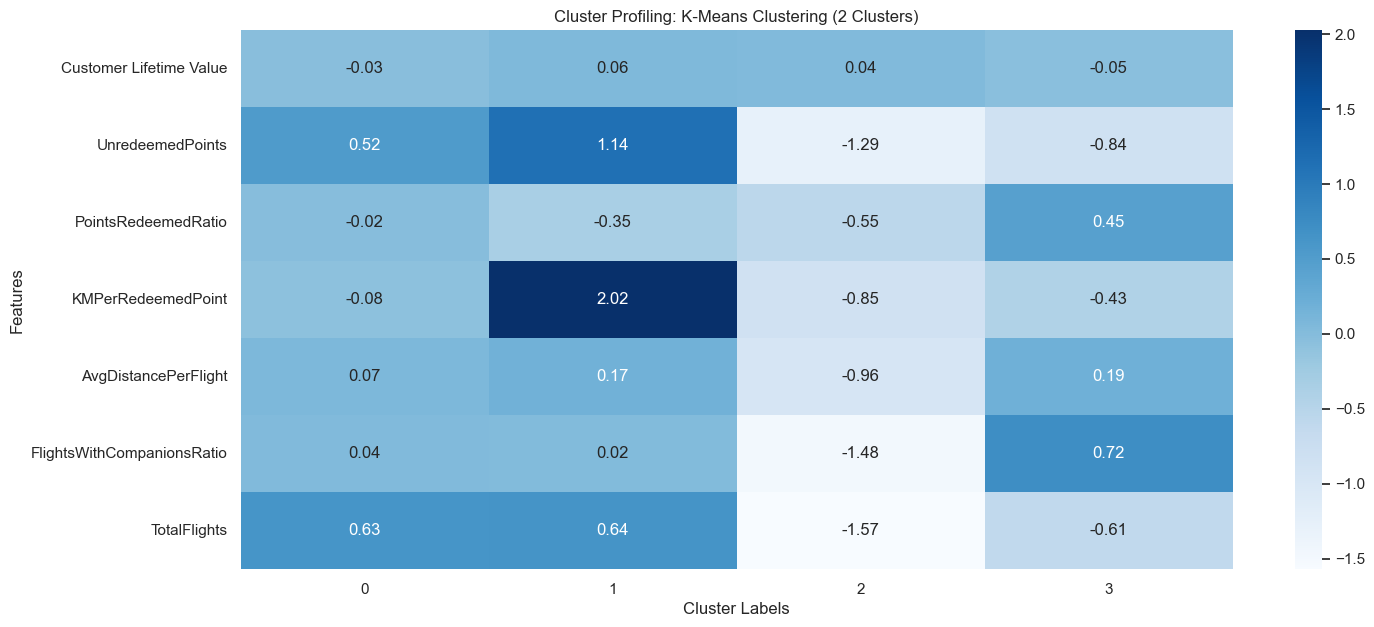

In [315]:
km = KMeans(n_clusters=4, init="k-means++", random_state=94)
km_labels_4 = km.fit_predict(df)

df_value_based_with_clusters = df.copy()
df_value_based_with_clusters['cluster'] = km_labels_4
cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (2 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()


cluster,0,1,2,3,4
Customer Lifetime Value,-0.043448,0.052188,0.042774,-0.061986,-0.016687
UnredeemedPoints,1.090736,1.154086,-1.292810,-0.909695,0.244925
PointsRedeemedRatio,-0.588656,-0.335421,-0.552977,0.430926,0.189094
KMPerRedeemedPoint,-0.867802,1.944979,-0.847426,-0.461365,0.096177
AvgDistancePerFlight,0.109708,0.178540,-0.972810,0.214833,0.055392
FlightsWithCompanionsRatio,-0.128086,0.012233,-1.486340,0.781022,0.122187
TotalFlights,0.400049,0.662760,-1.575824,-0.777973,0.642834


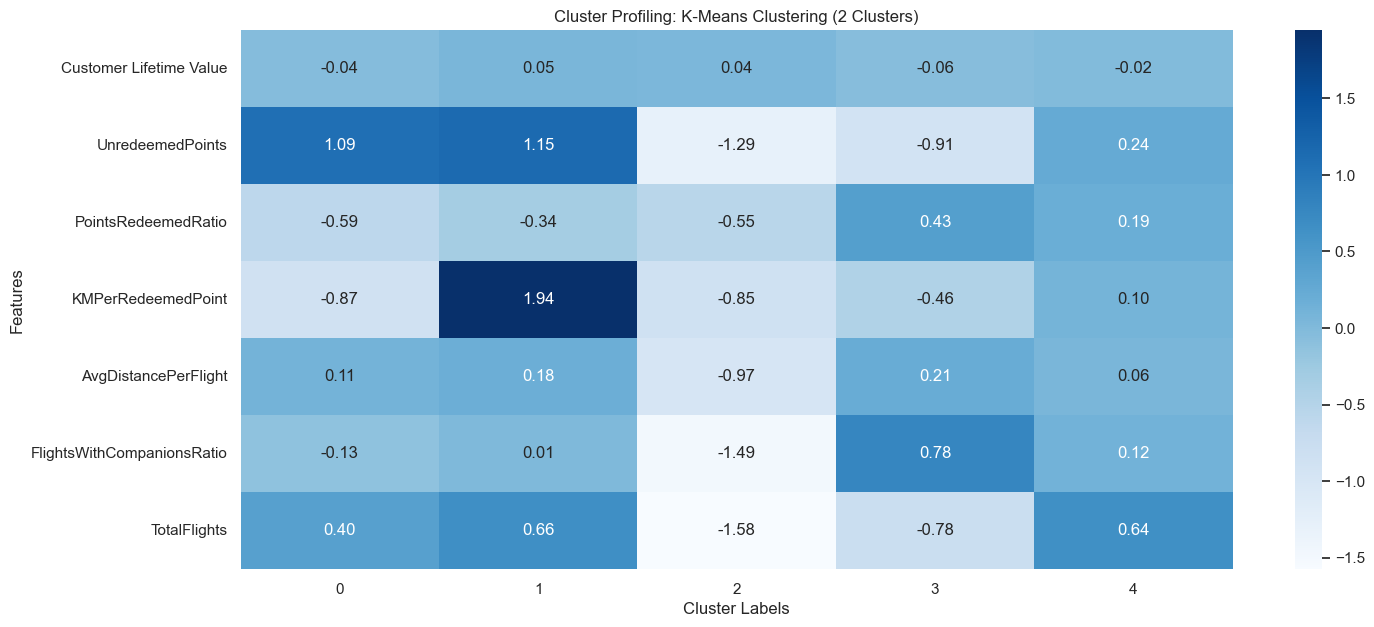

In [316]:
km = KMeans(n_clusters=5, init="k-means++", random_state=94)
km_labels_5 = km.fit_predict(df)

df_value_based_with_clusters = df.copy()
df_value_based_with_clusters['cluster'] = km_labels_5
cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (2 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()


In [317]:
# Features used for clustering
X = df
# Compute metrics for KMeans with 2 clusters
kmeans_2_silhouette = silhouette_score(X, km_labels_2)
kmeans_2_calinski_harabasz = calinski_harabasz_score(X, km_labels_2)
kmeans_2_davies_bouldin = davies_bouldin_score(X, km_labels_2)
# Compute metrics for KMeans with 3 clusters
kmeans_3_silhouette = silhouette_score(X, km_labels_3)
kmeans_3_calinski_harabasz = calinski_harabasz_score(X, km_labels_3)
kmeans_3_davies_bouldin = davies_bouldin_score(X, km_labels_3)

# Compute metrics for KMeans with 4 clusters
kmeans_4_silhouette = silhouette_score(X, km_labels_4)
kmeans_4_calinski_harabasz = calinski_harabasz_score(X, km_labels_4)
kmeans_4_davies_bouldin = davies_bouldin_score(X, km_labels_4)

# Compute metrics for KMeans with 5 clusters
kmeans_5_silhouette = silhouette_score(X, km_labels_5)
kmeans_5_calinski_harabasz = calinski_harabasz_score(X, km_labels_5)
kmeans_5_davies_bouldin = davies_bouldin_score(X, km_labels_5)
# Create a comparison table
comparison_table = pd.DataFrame({
    "Clustering Method": ["Hierarchical (4 Clusters)", "Hierarchical (3 Clusters)", "K-Means (2 Clusters)", "K-Means (3 Clusters)", "K-Means (4 Clusters)", "K-Means (5 Clusters)"],
    "Silhouette Score": [silhouette_score(X, hc_labels4), silhouette_score(X, hc_labels3), kmeans_2_silhouette, kmeans_3_silhouette, kmeans_4_silhouette, kmeans_5_silhouette],
    "Calinski-Harabasz Index": [calinski_harabasz_score(X, hc_labels4), calinski_harabasz_score(X, hc_labels3), kmeans_2_calinski_harabasz, kmeans_3_calinski_harabasz, kmeans_4_calinski_harabasz, kmeans_5_calinski_harabasz],
    "Davies-Bouldin Index": [davies_bouldin_score(X, hc_labels4), davies_bouldin_score(X, hc_labels3), kmeans_2_davies_bouldin, kmeans_3_davies_bouldin, kmeans_4_davies_bouldin, kmeans_5_davies_bouldin]
})
comparison_table.head(6)

,Clustering Method,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index
0,Hierarchical (4 Clusters),0.231889,4472.407300,1.443123
1,Hierarchical (3 Clusters),0.232505,4682.002636,1.290380
2,K-Means (2 Clusters),0.307698,6413.689416,1.414508
3,K-Means (3 Clusters),0.258656,5727.045935,1.400507
4,K-Means (4 Clusters),0.261758,5366.577856,1.381575
5,K-Means (5 Clusters),0.240872,4610.621523,1.457196


### Conclusion 
    
    K-Means (2 Clusters) is the best because it achieves the highest Silhouette Score (0.307) and Calinski-Harabasz Index (6413) while maintaining Davies-Bouldin Index as 1.414.

    In addition, in terms of insights for customer segmentation analysis and marketing strategies is the best choice.



Let's check for DBSCAN since it works well with outliers and works with dense regions.

KMeans has some limitations, such as assuming globular clusters and sensitivity to outliers, so that's why we are going to test DBSCAN, Mean Shift and GMM.

For GMM, Mean Shift and DBSCAN we will use all dataset (including outliers).

DBSCAN will be use to detect VIP Customers.

## Mean Shift

In [318]:
bandwidth = estimate_bandwidth(df_value_based, quantile=0.3, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df_value_based)

In [319]:
n_clusters = len(np.unique(ms_labels))
print(pd.Series(ms_labels).value_counts().sort_index())

0     16431
1        45
2         8
3         5
4         6
5         4
6         6
7         4
8         2
9         3
10        2
11        1
12        1
13        3
14        1
15       39
16        1
17        1
18        4
19        2
20        1
21        1
22        1
23        1
24        1
Name: count, dtype: int64


In [320]:
# Combine original features with cluster labels
df_with_labels = df_value_based.copy()
df_with_labels['labels'] = ms_labels

# Function to compute R²
def get_rsq(df, features, label_col):
    overall_mean = df[features].mean()
    ss_total = ((df[features] - overall_mean)**2).sum().sum()
    ss_within = df.groupby(label_col)[features].apply(lambda x: ((x - x.mean())**2).sum()).sum()
    return 1 - ss_within / ss_total

# Compute R² for Mean Shift clustering
r2_mshift = get_rsq(df_with_labels, value_features, 'labels')
print("R² for Mean Shift Clustering:", r2_mshift)


R² for Mean Shift Clustering: Customer Lifetime Value       0.858197
UnredeemedPoints              0.859382
PointsRedeemedRatio           0.948011
KMPerRedeemedPoint            0.857953
AvgDistancePerFlight          0.939873
FlightsWithCompanionsRatio    0.873096
TotalFlights                  0.860332
dtype: float64


With quantile = 0.3 we have 24 clusters wich are a lot. 

In [321]:

# Compute metrics in PCA space
silhouette = silhouette_score(df_value_based, ms_labels)
calinski = calinski_harabasz_score(df_value_based, ms_labels)
davies_bouldin = davies_bouldin_score(df_value_based, ms_labels)

print("Mean Shift Clustering Metrics:")
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski)
print("Davies-Bouldin Index:", davies_bouldin)

Mean Shift Clustering Metrics:
Silhouette Score: 0.5340744578126572
Calinski-Harabasz Index: 168.9970244039696
Davies-Bouldin Index: 0.5928123362241611


## GMM

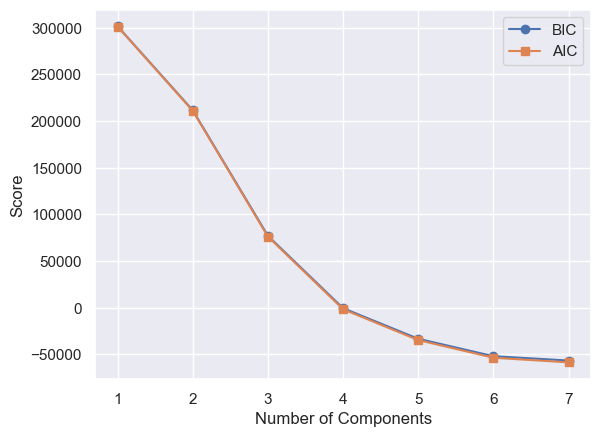

In [322]:
from sklearn.mixture import GaussianMixture

# Decide number of components to test
n_components = np.arange(1, 8)

bic_values = []
aic_values = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, covariance_type='full', n_init=10, random_state=1)
    gmm.fit(df_value_based)  # or df_value_based
    bic_values.append(gmm.bic(df_value_based))
    aic_values.append(gmm.aic(df_value_based))

# Plot BIC and AIC
plt.plot(n_components, bic_values, 'o-', label='BIC')
plt.plot(n_components, aic_values, 's-', label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.xticks(n_components)
plt.legend()
plt.show()


In [323]:
best_gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, random_state=1)
gmm_labels = best_gmm.fit_predict(df_value_based)

In [324]:
silhouette = silhouette_score(df_value_based, gmm_labels)
calinski = calinski_harabasz_score(df_value_based, gmm_labels)
davies_bouldin = davies_bouldin_score(df_value_based, gmm_labels)

print("GMM Metrics:")
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski)
print("Davies-Bouldin Index:", davies_bouldin)

GMM Metrics:
Silhouette Score: 0.24888233013342023
Calinski-Harabasz Index: 2479.8109904175544
Davies-Bouldin Index: 1.7415388022626852


## DBSCAN

Since we have a lot of outliers in our dataset, we will use DBSCAN since this algorithm handles well with outliers.

In [325]:
# Run DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)  # adjust eps/min_samples as needed
db_labels = dbscan.fit_predict(df_value_based)

In [326]:
mask = db_labels != -1
X_filtered = df_value_based[mask]
labels_filtered = db_labels[mask]

In [327]:
silhouette = silhouette_score(X_filtered, labels_filtered)
calinski = calinski_harabasz_score(X_filtered, labels_filtered)
davies_bouldin = davies_bouldin_score(X_filtered, labels_filtered)

print("DBSCAN Metrics (excluding noise):")
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski)
print("Davies-Bouldin Index:", davies_bouldin)


DBSCAN Metrics (excluding noise):
Silhouette Score: 0.8296302502387849
Calinski-Harabasz Index: 281.9395387263044
Davies-Bouldin Index: 0.16934209813220333


| METHOD | Silhouette | Calinski-Harabasz| Davies-Bouldin Index | 
| --- | --- | --- | --- |
| K Means 2 clusters | 0.30 | 6413 | 1.4 | 
| GMM | 0.24 | 2479 | 1.74|
| DSCAN | 0.82| 281 | 0.16 | 
| Mean Shift | 0.53 | 168 | 0.59 | 


With this table, we can see that DBSCAN has the best Silhouete score, which means that is the best method to separate clusters, however we will choose Hierarchical 2 Clusters since DBSCAN does not take into account outliers, the reason why we have a high score.

After defining that the method is K Means Clustering (2), we will use DBSCAN to add a label where we will have VIP customers, since this are the outliers.

What we are going to do next is using K Means with GMM.

## Final Clustering

In [328]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(df)

print(f"  Cluster 0: {np.sum(kmeans_labels == 0):,} customers")
print(f"  Cluster 1: {np.sum(kmeans_labels == 1):,} customers")


  Cluster 0: 10,871 customers
  Cluster 1: 5,607 customers


In [329]:
gmm = GaussianMixture(n_components=2, random_state=42, n_init=10)
gmm.fit(df)

,n_components,2
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,10
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


In [330]:
gmm_probabilities = gmm.predict_proba(df)
gmm_labels = gmm.predict(df)

In [331]:
results_df = pd.DataFrame()
results_df['kmeans_cluster'] = kmeans_labels
results_df['gmm_cluster'] = gmm_labels

# Add probability scores
results_df['prob_cluster_0'] = gmm_probabilities[:, 0]
results_df['prob_cluster_1'] = gmm_probabilities[:, 1]

# Calculate confidence (max probability)
results_df['confidence'] = np.max(gmm_probabilities, axis=1)

# Identify borderline customers (low confidence)
results_df['borderline'] = results_df['confidence'] < 0.7

In [332]:
print(results_df['kmeans_cluster'].value_counts().sort_index())

print(f"\nConfidence Statistics:")
print(f"  Mean confidence: {results_df['confidence'].mean():.3f}")
print(f"  Median confidence: {results_df['confidence'].median():.3f}")
print(f"  Min confidence: {results_df['confidence'].min():.3f}")
print(f"  Max confidence: {results_df['confidence'].max():.3f}")

borderline_count = results_df['borderline'].sum()
print(f"\nBorderline Customers (confidence < 0.7):")
print(f"  {borderline_count:,} customers ({(borderline_count/len(results_df)*100):.1f}%)")


kmeans_cluster
0    10871
1     5607
Name: count, dtype: int64

Confidence Statistics:
  Mean confidence: 0.988
  Median confidence: 1.000
  Min confidence: 0.500
  Max confidence: 1.000

Borderline Customers (confidence < 0.7):
  241 customers (1.5%)


This results shows that the two clusters are well separated and the mean of 98% means that most customers are correctly in theis cluster.

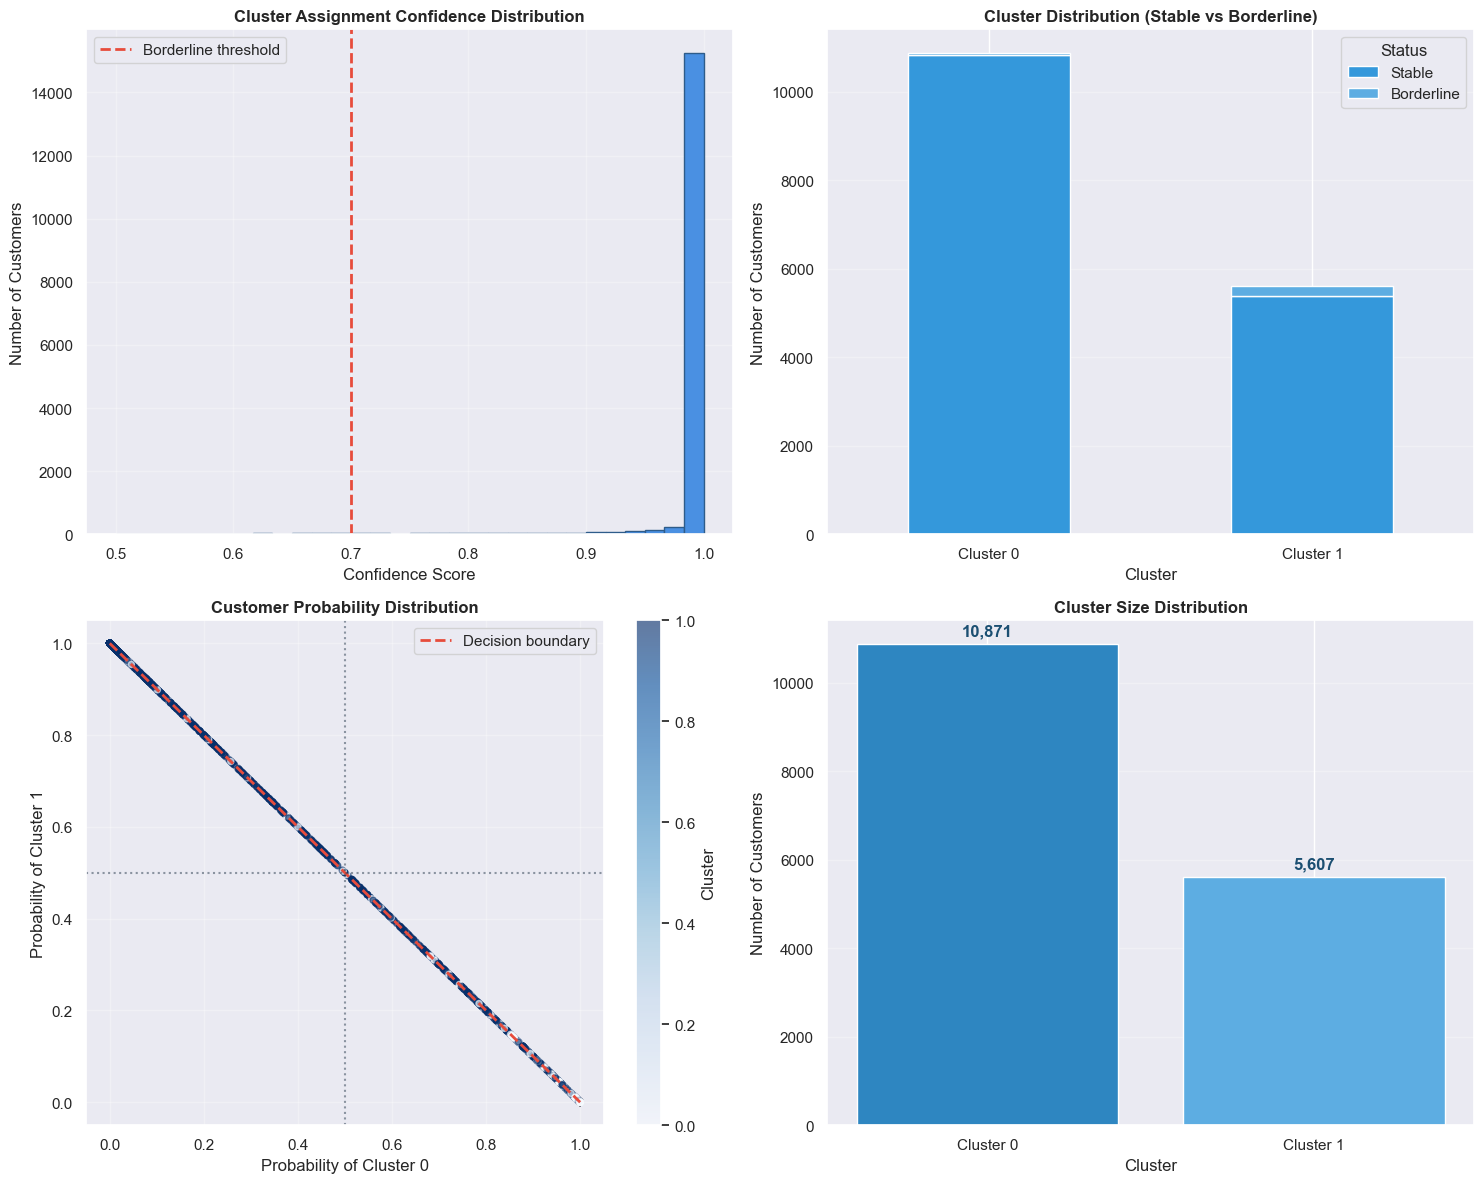

Visualization saved as 'gmm_clustering_analysis.png'


In [333]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Confidence distribution
axes[0, 0].hist(results_df['confidence'], bins=30, color='#4A90E2', edgecolor='#2E5C8A')
axes[0, 0].axvline(x=0.7, color='#E74C3C', linestyle='--', linewidth=2, label='Borderline threshold')
axes[0, 0].set_title('Cluster Assignment Confidence Distribution', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Confidence Score')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Cluster distribution with borderline
cluster_border = results_df.groupby(['kmeans_cluster', 'borderline']).size().unstack(fill_value=0)
cluster_border.plot(kind='bar', stacked=True, ax=axes[0, 1], color=['#3498DB', '#5DADE2'])
axes[0, 1].set_title('Cluster Distribution (Stable vs Borderline)', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].legend(['Stable', 'Borderline'], title='Status')
axes[0, 1].set_xticklabels(['Cluster 0', 'Cluster 1'], rotation=0)
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Probability scatter
scatter = axes[1, 0].scatter(results_df['prob_cluster_0'], results_df['prob_cluster_1'], 
                c=results_df['kmeans_cluster'], cmap='Blues', alpha=0.6, s=20)
axes[1, 0].plot([0, 1], [1, 0], 'r--', linewidth=2, label='Decision boundary', color='#E74C3C')
axes[1, 0].axhline(y=0.5, color='#2C3E50', linestyle=':', alpha=0.5)
axes[1, 0].axvline(x=0.5, color='#2C3E50', linestyle=':', alpha=0.5)
axes[1, 0].set_title('Customer Probability Distribution', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Probability of Cluster 0')
axes[1, 0].set_ylabel('Probability of Cluster 1')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='Cluster')

# Plot 4: Cluster sizes
cluster_counts = results_df['kmeans_cluster'].value_counts().sort_index()
axes[1, 1].bar(cluster_counts.index, cluster_counts.values, color=['#2E86C1', '#5DADE2'])
axes[1, 1].set_title('Cluster Size Distribution', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Number of Customers')
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(['Cluster 0', 'Cluster 1'])
for i, v in enumerate(cluster_counts.values):
    axes[1, 1].text(i, v + 200, f'{v:,}', ha='center', fontweight='bold', color='#1B4F72')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('gmm_clustering_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as 'gmm_clustering_analysis.png'")

## 5. Cluster Profiling

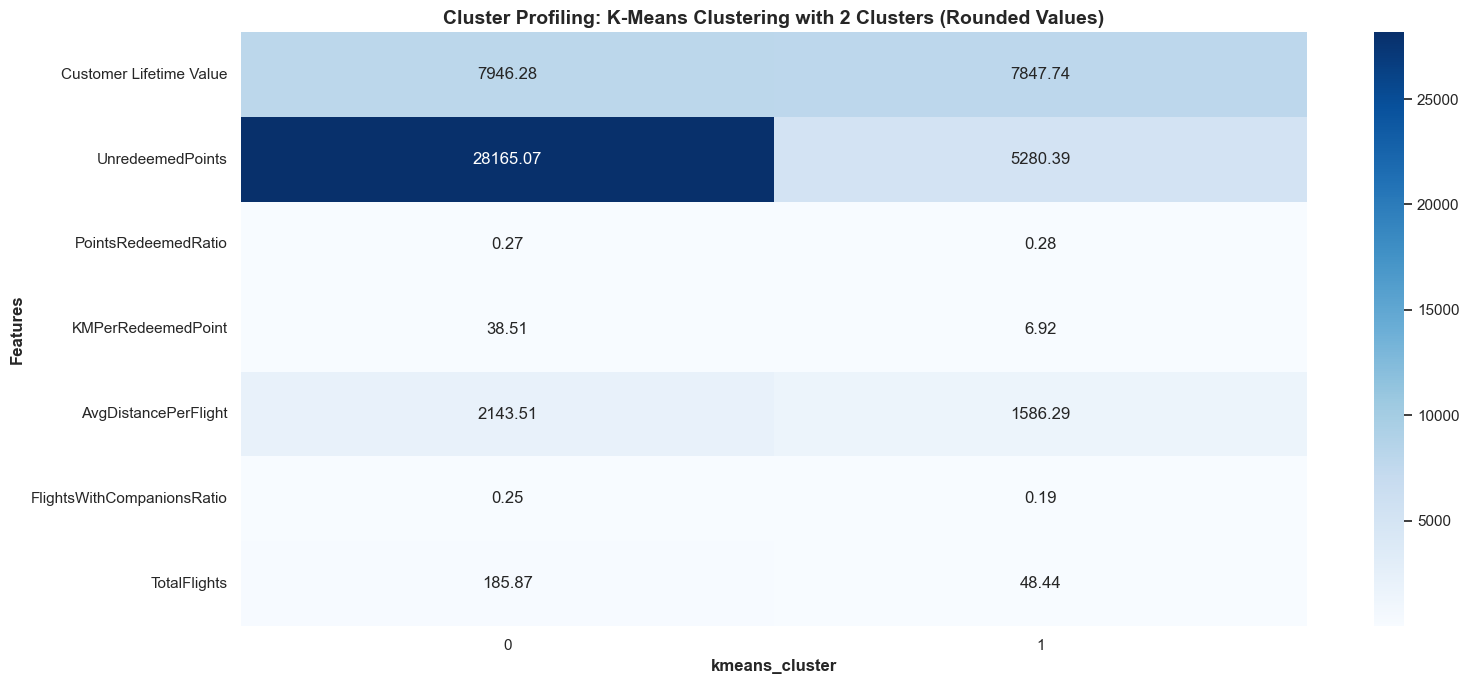

In [334]:
# add kmeans cluster labels to df
df['kmeans_cluster'] = results_df['kmeans_cluster'].values

features_to_cluster = df.columns.drop('kmeans_cluster')
# Inverse transform to get original scale
df_original_scale = pd.DataFrame(
    scaler.inverse_transform(df[features_to_cluster]),
    columns=features_to_cluster,
    index=df.index
)

# Add cluster labels
df_original_scale['kmeans_cluster'] = df['kmeans_cluster'].values

# Calculate mean per cluster (in original scale)
cluster_profile_original = df_original_scale.groupby('kmeans_cluster')[features_to_cluster].mean()


plt.figure(figsize=(16, 7))
sns.heatmap(cluster_profile_original.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering with 2 Clusters (Rounded Values)", 
          fontweight='bold', fontsize=14)
plt.xlabel("kmeans_cluster", fontweight='bold')
plt.ylabel("Features", fontweight='bold')
plt.tight_layout()
plt.show()


Let's add the df_out (VIP Customes) and use PCA for visualization

In [335]:
df_out['kmeans_cluster'] = 2
# df_out in scaler transform
df_out_original_scale = pd.DataFrame(
    scaler.inverse_transform(df_out[value_features]),
    columns=value_features,
    index=df_out.index
)
df_out_original_scale['kmeans_cluster'] = df_out['kmeans_cluster'].values

In [336]:
df_combined = pd.concat([df_original_scale, df_out_original_scale], axis=0)
df_combined


,Customer Lifetime Value,UnredeemedPoints,PointsRedeemedRatio,KMPerRedeemedPoint,AvgDistancePerFlight,FlightsWithCompanionsRatio,TotalFlights,kmeans_cluster
0,7919.20,32446.0,0.387904,25.786888,2356.577778,0.200000,225.0,0
1,2887.74,15141.0,0.553363,18.077435,1384.141224,0.224490,245.0,0
2,2838.07,38293.0,0.113362,88.241585,2047.539336,0.241706,211.0,0
3,4170.57,23544.0,0.354092,28.248369,3375.941667,0.157407,108.0,0
4,6622.05,32058.0,0.253580,39.448214,2373.649171,0.276243,181.0,0
...,...,...,...,...,...,...,...,...
15663,5744.23,0.0,3.254031,3.074980,2102.944444,0.666667,18.0,2
15931,8092.88,0.0,7.300871,1.371109,665.421053,0.736842,19.0,2
16045,40235.97,0.0,7.053571,1.418758,2353.720000,1.000000,5.0,2
16169,8694.00,2643.0,0.000000,0.000000,26432.000000,1.000000,1.0,2


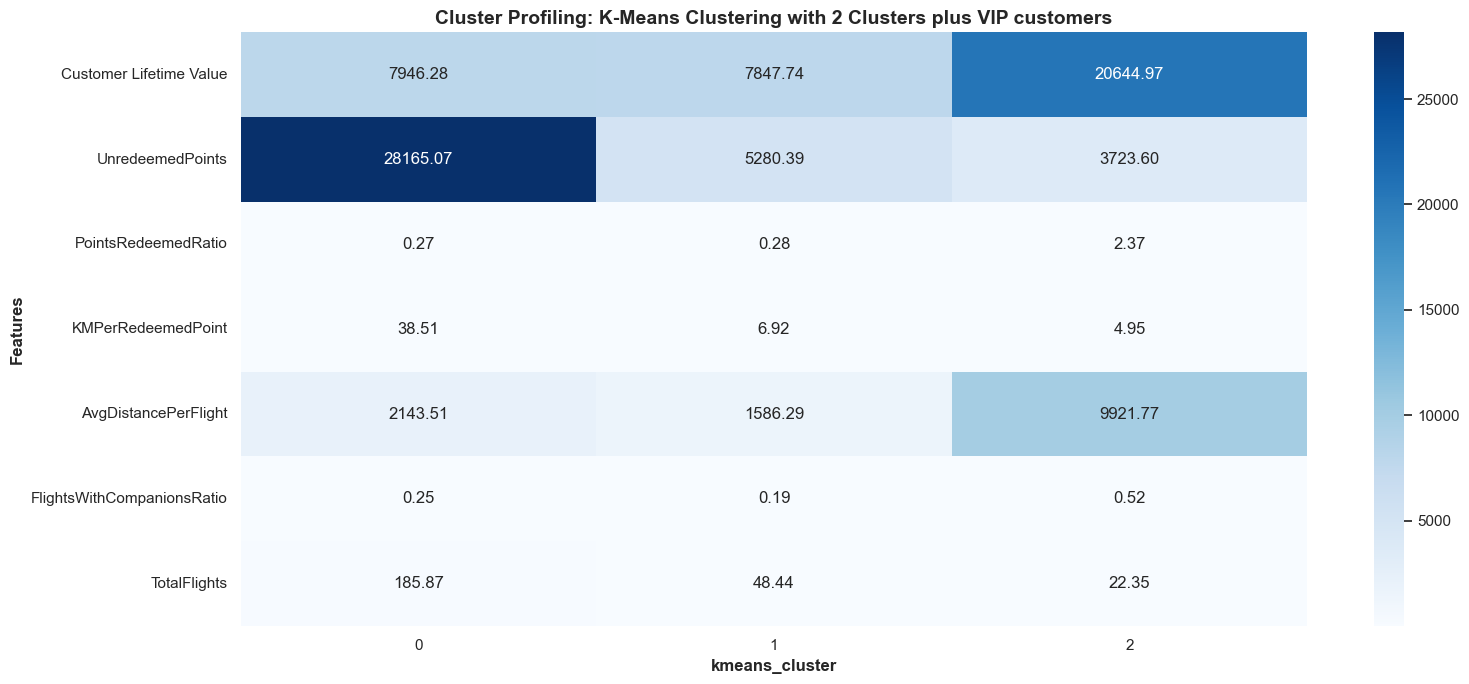

In [337]:
# Calculate mean per cluster (in original scale)
value_based_final = df_combined.groupby('kmeans_cluster')[features_to_cluster].mean()


plt.figure(figsize=(16, 7))
sns.heatmap(value_based_final.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering with 2 Clusters plus VIP customers", 
          fontweight='bold', fontsize=14)
plt.xlabel("kmeans_cluster", fontweight='bold')
plt.ylabel("Features", fontweight='bold')
plt.tight_layout()
plt.show()

In [338]:
# To csv the df_combined with just the column kmeans_cluster 
df_combined[['kmeans_cluster']].to_csv("value_based_clusters.csv", index=False)

### Purchasing Patterns by Cluster

Based on the K-means clustering with 2 clusters plus DBSCAN (VIP customers), the purchasing behavior can be summarized as follows:

#### 1. **High Value, Active Flyers (Cluster 0)**
- **Pattern**: Frequent, engaged flyers who accumulate lots of points, fly longer distances and are very active in the loyalty program.
- **Peak**: Massive points accumulated and huge avg distance per flight.


#### 2. **Occasional Travelers (Cluster 1)**
- **Pattern**: Customers in this cluster have minimal flight activity and engagement with the loyalty program, with significantly lower metrics across all features.
- **Peak**: CLV, which is surprisingly similar to cluster 0
- **Trend**:  Consistently low activity across all behavioral metrics

#### 3. **VIP Customers (Cluster 2)**
- **Pattern**: Customers who have less flights, but in comparison with the kilometers they do much more than the others. They have a big customer lifetime value and they rescue 2x more points that the ones they accumulated, so they must receive bonus points for the company and the loyalty program.

